# 🛡️ Defending Against Deepfakes: Texture Feature Perturbation

## Based on: "Defending Deepfake via Texture Feature Perturbation" (Zhang et al., 2025)

---

### 🎯 Objective
**Proactively protect images from deepfake manipulation by injecting invisible "vaccinations" into texture regions.**

### 💡 Key Innovation
- Traditional methods: Detect deepfakes AFTER creation
- Our approach: PREVENT deepfakes BEFORE creation
- How: Add imperceptible perturbations to texture-rich regions

### 📊 Demo Structure
1. ✅ **Clean Image** → StarGAN Deepfake → **Success** (manipulation works)
2. 🛡️ **Vaccinated Image** → StarGAN Deepfake → **FAILURE** (manipulation breaks)

---

## 📦 Installation & Setup

In [1]:
# Create/reuse dedicated virtual environment and install dependencies
# Works on macOS (Apple Silicon), Linux, and Windows.
import os
import sys
import subprocess
import venv
from pathlib import Path

VENV_DIR = Path('.venv_deepfake')
if os.name == 'nt':
    VENV_PY = VENV_DIR / 'Scripts' / 'python.exe'
else:
    VENV_PY = VENV_DIR / 'bin' / 'python'

if not VENV_PY.exists():
    print(f"📦 Creating virtual environment at {VENV_DIR} ...")
    venv.EnvBuilder(with_pip=True, clear=False).create(VENV_DIR)
else:
    print(f"✅ Reusing virtual environment at {VENV_DIR}")

def run(cmd):
    print('>', ' '.join(str(x) for x in cmd))
    subprocess.check_call([str(x) for x in cmd])

packages = [
    'torch', 'torchvision', 'torchaudio',
    'opencv-python', 'scikit-image', 'matplotlib', 'seaborn',
    'pillow', 'numpy', 'scipy', 'tqdm',
    'timm', 'gradio==3.50.2', 'gdown', 'requests', 'certifi', 'ipykernel'
]

marker = VENV_DIR / '.deps_installed_v3'
if not marker.exists():
    run([VENV_PY, '-m', 'pip', 'install', '--upgrade', 'pip', 'setuptools', 'wheel'])
    run([VENV_PY, '-m', 'pip', 'install', '-q', *packages])
    marker.write_text('ok\n')
    print('✅ Dependencies installed into managed venv.')
else:
    print('✅ Dependencies already installed (marker found); skipping pip install.')

kernel_name = 'deepfake-defense-venv'
display_name = 'Python (deepfake-defense-venv)'
run([VENV_PY, '-m', 'ipykernel', 'install', '--user', '--name', kernel_name, '--display-name', display_name])

current_py = Path(sys.executable).resolve()
target_py = Path(VENV_PY).resolve()
print(f"Current kernel python: {current_py}")
print(f"Target venv python:    {target_py}")

if current_py != target_py:
    print("\n⚠️ Switch Jupyter kernel to 'Python (deepfake-defense-venv)' and re-run from the top.")
else:
    print("\n✅ Notebook is already using the managed virtual environment.")


✅ Reusing virtual environment at .venv_deepfake
> .venv_deepfake/bin/python -m pip install --upgrade pip setuptools wheel
> .venv_deepfake/bin/python -m pip install -q torch torchvision torchaudio opencv-python scikit-image matplotlib seaborn pillow numpy scipy tqdm timm gradio==3.50.2 gdown requests certifi ipykernel
✅ Dependencies installed into managed venv.
> .venv_deepfake/bin/python -m ipykernel install --user --name deepfake-defense-venv --display-name Python (deepfake-defense-venv)
Installed kernelspec deepfake-defense-venv in /Users/ashwatthaphatak/Library/Jupyter/kernels/deepfake-defense-venv
Current kernel python: /Users/ashwatthaphatak/Desktop/A_NCSU/A SPRING 2026/0x0/.venv_deepfake/bin/python
Target venv python:    /Users/ashwatthaphatak/Desktop/A_NCSU/A SPRING 2026/0x0/.venv_deepfake/bin/python

✅ Notebook is already using the managed virtual environment.


## 📚 Import Libraries

In [2]:
import os
os.environ.setdefault('PYTORCH_ENABLE_MPS_FALLBACK', '1')  # CPU fallback for unsupported MPS ops

import certifi
import ssl

# Ensure urllib/torch hub/model downloads use a valid CA bundle.
os.environ.setdefault('SSL_CERT_FILE', certifi.where())
os.environ.setdefault('REQUESTS_CA_BUNDLE', certifi.where())
os.environ.setdefault('CURL_CA_BUNDLE', certifi.where())

def _certifi_https_context(*args, **kwargs):
    return ssl.create_default_context(cafile=certifi.where())

ssl._create_default_https_context = _certifi_https_context
print(f"🔐 SSL CA bundle: {certifi.where()}")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# LPIPS is optional in this notebook path.
try:
    import lpips
    LPIPS_AVAILABLE = True
except Exception as e:
    lpips = None
    LPIPS_AVAILABLE = False
    print(f"⚠️ LPIPS unavailable: {e}")

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Device setup (CUDA -> MPS -> CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"🚀 Using device: {device}")
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"🚀 Using device: {device}")
    print('   Backend: Apple Metal Performance Shaders (MPS)')
else:
    device = torch.device('cpu')
    print(f"🚀 Using device: {device}")
    if hasattr(torch.backends, 'mps') and torch.backends.mps.is_built():
        print('   ℹ️ MPS is built but unavailable (macOS/device/runtime mismatch).')


🔐 SSL CA bundle: /Users/ashwatthaphatak/Desktop/A_NCSU/A SPRING 2026/0x0/.venv_deepfake/lib/python3.10/site-packages/certifi/cacert.pem
🚀 Using device: mps
   Backend: Apple Metal Performance Shaders (MPS)


/Users/ashwatthaphatak/Desktop/A_NCSU/A SPRING 2026/0x0/.venv_deepfake/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 🔧 Utility Functions

In [3]:
def tensor_to_numpy(tensor):
    if len(tensor.shape) == 4:
        tensor = tensor[0]
    return tensor.cpu().permute(1, 2, 0).numpy()

def calculate_metrics(img1, img2):
    from skimage.metrics import structural_similarity as ssim
    from skimage.metrics import peak_signal_noise_ratio as psnr

    if torch.is_tensor(img1):
        img1 = tensor_to_numpy(img1)
    if torch.is_tensor(img2):
        img2 = tensor_to_numpy(img2)

    psnr_val = psnr(img1, img2, data_range=1.0)
    ssim_val = ssim(img1, img2, channel_axis=2, data_range=1.0)
    l2_dist = np.linalg.norm(img1 - img2)

    return {'PSNR': psnr_val, 'SSIM': ssim_val, 'L2': l2_dist}

def show_cam_on_image(img, mask, use_rgb=True, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

print("✅ Utilities loaded!")

✅ Utilities loaded!


## 🎯 Grad-CAM Implementation

In [4]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1)

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        gradients = self.gradients
        activations = self.activations
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.unsqueeze(1)

print("✅ Grad-CAM implemented!")

✅ Grad-CAM implemented!


## 🔍 Texture Extractor (LBP)

In [5]:
class TextureExtractor(nn.Module):
    def __init__(self):
        super(TextureExtractor, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.maxpool = nn.MaxPool2d(2, 2)

    def bilateral_filter(self, img_np, d=31, sigma_color=75, sigma_space=15):
        return cv2.bilateralFilter(img_np, d, sigma_color, sigma_space)

    def compute_lbp(self, img_np, radius=1, n_points=8):
        height, width = img_np.shape
        lbp = np.zeros((height, width), dtype=np.uint8)

        for i in range(radius, height - radius):
            for j in range(radius, width - radius):
                center = img_np[i, j]
                pattern = 0

                for p in range(n_points):
                    angle = 2 * np.pi * p / n_points
                    x = int(i + radius * np.cos(angle))
                    y = int(j - radius * np.sin(angle))
                    x = max(0, min(x, height - 1))
                    y = max(0, min(y, width - 1))

                    if img_np[x, y] >= center:
                        pattern += 2 ** p

                lbp[i, j] = pattern

        return lbp

    def forward(self, img_tensor):
        batch_size = img_tensor.shape[0]
        device = img_tensor.device

        texture_features = []

        for b in range(batch_size):
            img = img_tensor[b].cpu().numpy()
            gray = 0.299 * img[0] + 0.587 * img[1] + 0.116 * img[2]
            gray = (gray * 255).astype(np.uint8)
            filtered = self.bilateral_filter(gray)
            lbp = self.compute_lbp(filtered)
            lbp = lbp.astype(np.float32) / 255.0
            lbp_tensor = torch.from_numpy(lbp).unsqueeze(0).to(device)
            texture_features.append(lbp_tensor)

        # FIXED: Keep 4D shape (B, 1, H, W)
        lbp_batch = torch.stack(texture_features, dim=0)

        x = self.conv1(lbp_batch)
        x = self.conv2(x)
        x = self.maxpool(x)

        return x

print("✅ Texture Extractor implemented!")

✅ Texture Extractor implemented!


## 🎯 Attention Module

In [6]:
class DualAttentionModule:
    def __init__(self, device):
        self.device = device
        self.resnet = models.resnet50(pretrained=True).to(device).eval()
        self.gradcam_resnet = GradCAM(
            model=self.resnet,
            target_layer=self.resnet.layer4[-1]
        )
        print("✅ Attention Module loaded")

    def get_attention_map(self, img_tensor):
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        img_normalized = normalize(img_tensor.squeeze(0))
        img_input = img_normalized.unsqueeze(0)
        img_resized = F.interpolate(img_input, size=(224, 224), mode='bilinear', align_corners=False)

        with torch.enable_grad():
            cam_tensor = self.gradcam_resnet(img_resized)

        original_size = img_tensor.shape[2:]
        cam_resized = F.interpolate(cam_tensor, size=original_size, mode='bilinear', align_corners=False)

        return cam_resized

print("✅ Attention Module implemented!")

✅ Attention Module implemented!


## ⚡ Perturbation Generator

In [7]:
class PerturbationEnhancement(nn.Module):
    def __init__(self):
        super(PerturbationEnhancement, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.attention_fusion = nn.Sequential(
            nn.Conv2d(129, 64, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, texture_features, attention_map):
        encoded = self.encoder(texture_features)
        attention_downsampled = F.interpolate(
            attention_map,
            size=encoded.shape[2:],
            mode='bilinear',
            align_corners=False
        )
        fused = torch.cat([encoded, attention_downsampled], dim=1)
        fused = self.attention_fusion(fused)
        perturbation = self.decoder(fused)
        return perturbation

print("✅ Perturbation Generator implemented!")

✅ Perturbation Generator implemented!


## 🔬 Defense Framework

In [8]:
class DeepfakeDefenseFramework(nn.Module):
    def __init__(self, epsilon=0.05):
        super(DeepfakeDefenseFramework, self).__init__()
        self.epsilon = epsilon
        self.texture_extractor = TextureExtractor()
        self.perturbation_gen = PerturbationEnhancement()

        # LPIPS is not used in the demo pipeline math, so skip by default.
        self.lpips_loss = None
        self.lpips_device = None

        if LPIPS_AVAILABLE and os.environ.get('ENABLE_LPIPS_INIT', '0') == '1':
            try:
                self.lpips_loss = lpips.LPIPS(net='alex').to(device)
                self.lpips_device = device
                print(f"✅ LPIPS initialized on {self.lpips_device}")
            except Exception as e:
                print(f"⚠️ LPIPS init on {device} failed: {e}")
                print('   Retrying LPIPS on CPU...')
                try:
                    self.lpips_loss = lpips.LPIPS(net='alex').to('cpu')
                    self.lpips_device = torch.device('cpu')
                    print('✅ LPIPS initialized on CPU')
                except Exception as e2:
                    print(f"⚠️ LPIPS disabled (cert/download issue): {e2}")
        else:
            print('ℹ️ LPIPS init skipped (not required for this demo).')

        print('✅ Defense Framework initialized!')

    def generate_perturbation(self, img_tensor, attention_map):
        texture_features = self.texture_extractor(img_tensor)
        perturbation = self.perturbation_gen(texture_features, attention_map)
        perturbation = self.epsilon * perturbation
        return perturbation

    def vaccinate_image(self, img_tensor, attention_map):
        with torch.no_grad():
            perturbation = self.generate_perturbation(img_tensor, attention_map)
            vaccinated = img_tensor + perturbation
            vaccinated = torch.clamp(vaccinated, 0, 1)
        return vaccinated, perturbation

defense_framework = DeepfakeDefenseFramework(epsilon=0.05).to(device)
print(f"✅ Framework ready on {device}!")


ℹ️ LPIPS init skipped (not required for this demo).
✅ Defense Framework initialized!
✅ Framework ready on mps!


In [9]:
import requests, zipfile
from pathlib import Path

CKPT_DIR  = Path("stargan_celeba_128/models")
CKPT_DIR.mkdir(parents=True, exist_ok=True)
ZIP_PATH  = CKPT_DIR / "celeba-128x128-5attrs.zip"
CKPT_PATH = CKPT_DIR / "200000-G.ckpt"

if not CKPT_PATH.exists():
    DROPBOX_URL = "https://www.dropbox.com/s/7e966qq0nlxwte4/celeba-128x128-5attrs.zip?dl=1"
    print("📥 Downloading StarGAN CelebA-128 weights from Dropbox …")
    r = requests.get(DROPBOX_URL, stream=True, timeout=120)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(ZIP_PATH, "wb") as f:
        downloaded = 0
        for chunk in r.iter_content(chunk_size=1 << 20):
            f.write(chunk); downloaded += len(chunk)
            print(f"\r   {downloaded/1e6:.1f} / {total/1e6:.1f} MB", end="")
    print()
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(CKPT_DIR)
    ZIP_PATH.unlink()
    print("✅ Download & extraction complete.")
else:
    print("✅ Checkpoint already present, skipping download.")

✅ Checkpoint already present, skipping download.


## 🤖 StarGAN Architecture

In [10]:
import torch
import torch.nn as nn

print(f"🔄 Loading weights from {CKPT_PATH} …")

# Keep checkpoint load portable across CUDA/MPS/CPU and torch versions.
try:
    state_dict = torch.load(CKPT_PATH, map_location="cpu", weights_only=True)
except TypeError:
    state_dict = torch.load(CKPT_PATH, map_location="cpu")

class ResidualBlock(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True),
        )

    def forward(self, x):
        return x + self.main(x)


class StarGANGenerator(nn.Module):
    def __init__(self, conv_dim=64, c_dim=5, repeat_num=6):
        super().__init__()
        layers = [
            nn.Conv2d(3 + c_dim, conv_dim, 7, 1, 3, bias=False),
            nn.InstanceNorm2d(conv_dim, affine=True),
            nn.ReLU(inplace=True),
        ]
        curr_dim = conv_dim
        for _ in range(2):
            layers += [
                nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1, bias=False),
                nn.InstanceNorm2d(curr_dim * 2, affine=True),
                nn.ReLU(inplace=True),
            ]
            curr_dim *= 2
        for _ in range(repeat_num):
            layers.append(ResidualBlock(curr_dim, curr_dim))
        for _ in range(2):
            layers += [
                nn.ConvTranspose2d(curr_dim, curr_dim // 2, 4, 2, 1, bias=False),
                nn.InstanceNorm2d(curr_dim // 2, affine=True),
                nn.ReLU(inplace=True),
            ]
            curr_dim //= 2
        layers += [nn.Conv2d(curr_dim, 3, 7, 1, 3, bias=False), nn.Tanh()]
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        c = c.view(c.size(0), c.size(1), 1, 1).expand(c.size(0), c.size(1), x.size(2), x.size(3))
        return self.main(torch.cat([x, c], dim=1))


🔄 Loading weights from stargan_celeba_128/models/200000-G.ckpt …


In [11]:
import torch

# Reuse the global device selected earlier (cuda / mps / cpu)
G = StarGANGenerator(conv_dim=64, c_dim=5, repeat_num=6).to(device)
# Strip legacy InstanceNorm running stats (checkpoint saved pre-PyTorch 0.4.0)
cleaned = {k: v for k, v in state_dict.items()
           if not (k.endswith(".running_mean") or k.endswith(".running_var"))}

G.load_state_dict(cleaned, strict=False)
G.eval()
print("✅ StarGAN Generator weights loaded successfully.")


✅ StarGAN Generator weights loaded successfully.


## 📥 DOWNLOAD PRE-TRAINED STARGAN WEIGHTS

**This is critical! We need trained weights for realistic deepfakes.**

In [12]:
import os, zipfile, requests, torch, torch.nn as nn
from pathlib import Path

CKPT_DIR  = Path("stargan_celeba_128/models")
CKPT_DIR.mkdir(parents=True, exist_ok=True)
ZIP_PATH  = CKPT_DIR / "celeba-128x128-5attrs.zip"
CKPT_PATH = CKPT_DIR / "200000-G.ckpt"

# ── 1. Download ──────────────────────────────────────────────────────────────
if not CKPT_PATH.exists():
    DROPBOX_URL = "https://www.dropbox.com/s/7e966qq0nlxwte4/celeba-128x128-5attrs.zip?dl=1"
    print("📥 Downloading StarGAN CelebA-128 weights from Dropbox …")
    r = requests.get(DROPBOX_URL, stream=True, timeout=120)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(ZIP_PATH, "wb") as f:
        downloaded = 0
        for chunk in r.iter_content(chunk_size=1 << 20):
            f.write(chunk); downloaded += len(chunk)
            print(f"\r   {downloaded/1e6:.1f} / {total/1e6:.1f} MB", end="")
    print()
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(CKPT_DIR)
    ZIP_PATH.unlink()
    print("✅ Extraction complete.")
else:
    print("✅ Checkpoint already present, skipping download.")

# ── 2. Define Generator ──────────────────────────────────────────────────────
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(dim, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(dim, affine=True))
    def forward(self, x): return x + self.main(x)

class StarGANGenerator(nn.Module):
    def __init__(self, conv_dim=64, c_dim=5, repeat_num=6):
        super().__init__()
        layers = [nn.Conv2d(3+c_dim, conv_dim, 7, 1, 3, bias=False),
                  nn.InstanceNorm2d(conv_dim, affine=True), nn.ReLU(inplace=True)]
        curr = conv_dim
        for _ in range(2):
            layers += [nn.Conv2d(curr, curr*2, 4, 2, 1, bias=False),
                       nn.InstanceNorm2d(curr*2, affine=True), nn.ReLU(inplace=True)]
            curr *= 2
        for _ in range(repeat_num):
            layers.append(ResidualBlock(curr))
        for _ in range(2):
            layers += [nn.ConvTranspose2d(curr, curr//2, 4, 2, 1, bias=False),
                       nn.InstanceNorm2d(curr//2, affine=True), nn.ReLU(inplace=True)]
            curr //= 2
        layers += [nn.Conv2d(curr, 3, 7, 1, 3, bias=False), nn.Tanh()]
        self.main = nn.Sequential(*layers)
    def forward(self, x, c):
        c = c.view(c.size(0), c.size(1), 1, 1).expand(c.size(0), c.size(1), x.size(2), x.size(3))
        return self.main(torch.cat([x, c], dim=1))

# ── 3. Load weights (strip legacy pre-0.4.0 InstanceNorm running stats) ──────
# Reuse global device chosen earlier (cuda / mps / cpu)
stargan_generator = StarGANGenerator(conv_dim=64, c_dim=5, repeat_num=6).to(device)

print(f"🔄 Loading weights from {CKPT_PATH} …")
state_dict = torch.load(CKPT_PATH, map_location="cpu")
cleaned    = {k: v for k, v in state_dict.items()
              if not (k.endswith(".running_mean") or k.endswith(".running_var"))}
stargan_generator.load_state_dict(cleaned, strict=False)
stargan_generator.eval()
print("✅ StarGAN Generator weights loaded successfully.")


✅ Checkpoint already present, skipping download.
🔄 Loading weights from stargan_celeba_128/models/200000-G.ckpt …
✅ StarGAN Generator weights loaded successfully.


## 📥 Load Sample Images

In [13]:
# ------------------------------------------------------------------
# Create directories
# ------------------------------------------------------------------
os.makedirs('sample_images', exist_ok=True)
os.makedirs('results', exist_ok=True)

# ------------------------------------------------------------------
# Use locally downloaded sample images
# (make sure these files exist in sample_images/)
# ------------------------------------------------------------------
sample_image_paths = [
    'sample_images/sample_0.jpg',
    'sample_images/sample_1.jpg',
    'sample_images/sample_2.jpg',
]

print("📂 Loading local sample images...")

# Validate files exist
valid_paths = []
for path in sample_image_paths:
    if os.path.exists(path):
        valid_paths.append(path)
        print(f"   ✅ Found {path}")
    else:
        print(f"   ⚠️ Missing {path}")

if len(valid_paths) == 0:
    print("\n⚠️ No local images found. Falling back to synthetic input.")
    test_img = torch.rand(1, 3, 256, 256).to(device)
    sample_image_paths = None
else:
    sample_image_paths = valid_paths
    print(f"\n✅ {len(sample_image_paths)} sample images ready!")

# ------------------------------------------------------------------
# Image preprocessing
# ------------------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

def load_image(image_path):
    """Load and preprocess image"""
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img_tensor

print("✅ Image loading utilities ready!")

📂 Loading local sample images...
   ✅ Found sample_images/sample_0.jpg
   ✅ Found sample_images/sample_1.jpg
   ✅ Found sample_images/sample_2.jpg

✅ 3 sample images ready!
✅ Image loading utilities ready!


## 🎬 Setup Attack Function

In [14]:
attention_module = DualAttentionModule(device)

def deepfake_attack(image_tensor, target_attribute):
    """
    Generate deepfake using StarGAN
    """
    with torch.no_grad():
        # StarGAN expects [-1, 1] input
        img_normalized = image_tensor * 2 - 1

        # Generate fake
        fake_img = stargan_generator(img_normalized, target_attribute)

        # Convert back to [0, 1]
        fake_img = (fake_img + 1) / 2
        fake_img = torch.clamp(fake_img, 0, 1)

    return fake_img

# Define attributes (CelebA format)
# [Black_Hair, Blond_Hair, Brown_Hair, Male, Young]
attributes = {
    'Blonde Hair': torch.tensor([[0, 1, 0, 0, 0]], dtype=torch.float32).to(device),
    'Old Age': torch.tensor([[0, 0, 0, 0, 0]], dtype=torch.float32).to(device),
    'Male': torch.tensor([[0, 0, 0, 1, 0]], dtype=torch.float32).to(device),
}

print("✅ Attack ready!")
print(f"   Attributes: {list(attributes.keys())}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/ashwatthaphatak/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:03<00:00, 31.4MB/s]


✅ Attention Module loaded
✅ Attack ready!
   Attributes: ['Blonde Hair', 'Old Age', 'Male']


## 🚀 RUN THE COMPLETE DEMO!

In [15]:
# Load test image
if sample_image_paths:
    original_image = load_image(sample_image_paths[0])
else:
    original_image = torch.rand(1, 3, 128, 128).to(device)

target_attr = 'Blonde Hair'
target_attr_tensor = attributes[target_attr]

print(f"🎯 Target: {target_attr}")
print(f"📸 Image: {original_image.shape}")

🎯 Target: Blonde Hair
📸 Image: torch.Size([1, 3, 256, 256])



STEP 1: Generating Attention Map


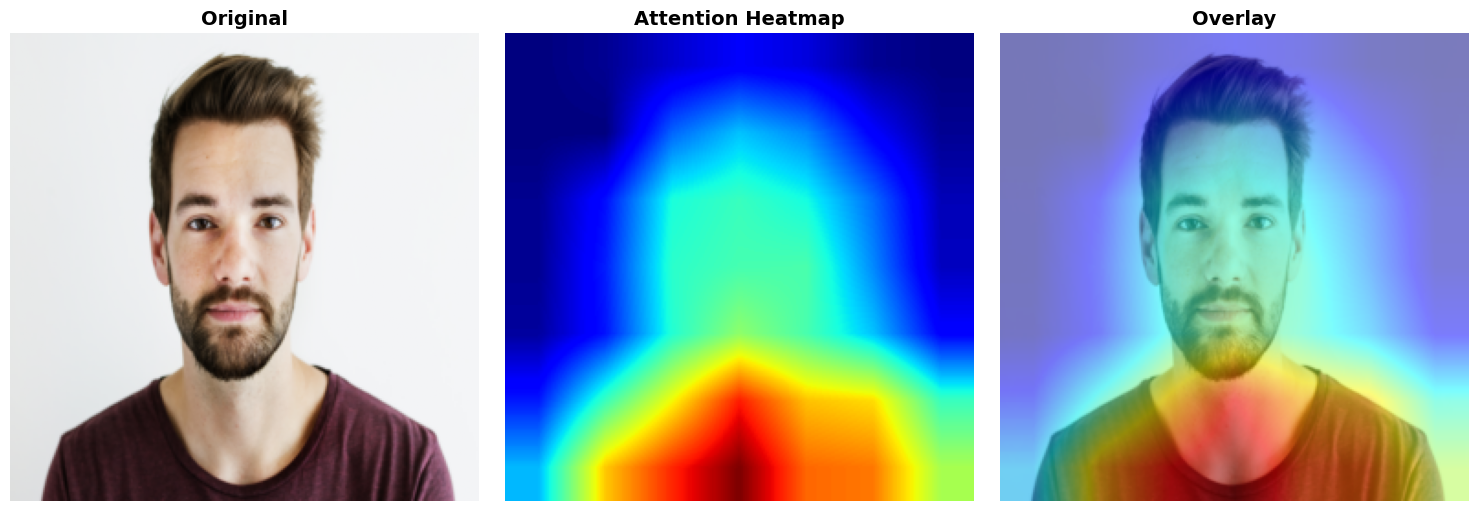

✅ Attention map generated!


In [16]:
# STEP 1: Attention Map
print("\n" + "="*60)
print("STEP 1: Generating Attention Map")
print("="*60)

attention_map = attention_module.get_attention_map(original_image)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(tensor_to_numpy(original_image))
axes[0].set_title('Original', fontsize=14, fontweight='bold')
axes[0].axis('off')

attention_np = attention_map[0, 0].cpu().numpy()
axes[1].imshow(attention_np, cmap='jet')
axes[1].set_title('Attention Heatmap', fontsize=14, fontweight='bold')
axes[1].axis('off')

img_np = tensor_to_numpy(original_image)
overlay = show_cam_on_image(img_np, attention_np)
axes[2].imshow(overlay)
axes[2].set_title('Overlay', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('results/step1_attention.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Attention map generated!")


STEP 2: Generating Perturbation


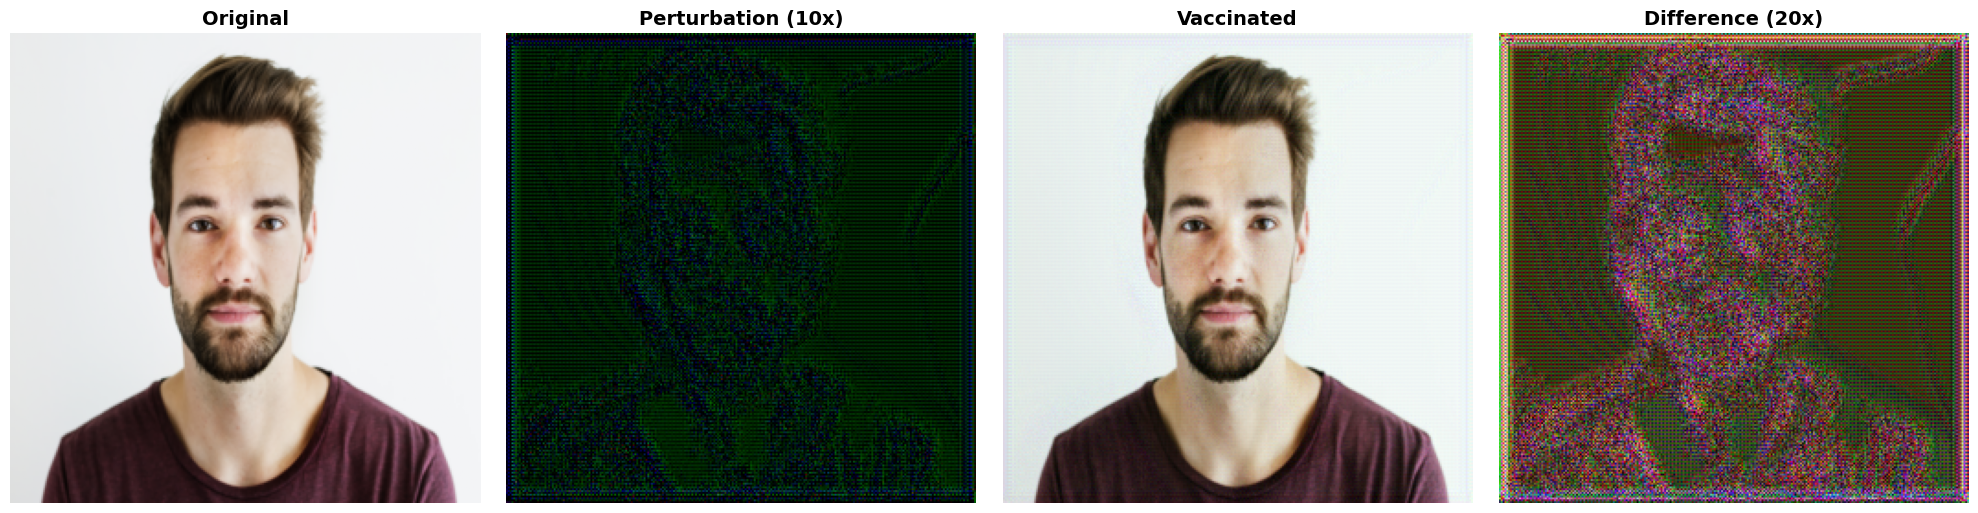


📊 Visual Quality:
   PSNR: 35.70 dB
   SSIM: 0.9269
   L2: 7.2733

✅ Perturbation imperceptible!


In [17]:
# STEP 2: Generate Perturbation
print("\n" + "="*60)
print("STEP 2: Generating Perturbation")
print("="*60)

vaccinated_image, perturbation = defense_framework.vaccinate_image(
    original_image,
    attention_map
)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(tensor_to_numpy(original_image))
axes[0].set_title('Original', fontsize=14, fontweight='bold')
axes[0].axis('off')

pert_amplified = (perturbation * 10).clamp(0, 1)
axes[1].imshow(tensor_to_numpy(pert_amplified))
axes[1].set_title('Perturbation (10x)', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(tensor_to_numpy(vaccinated_image))
axes[2].set_title('Vaccinated', fontsize=14, fontweight='bold')
axes[2].axis('off')

diff = torch.abs(vaccinated_image - original_image) * 20
axes[3].imshow(tensor_to_numpy(diff))
axes[3].set_title('Difference (20x)', fontsize=14, fontweight='bold')
axes[3].axis('off')

plt.tight_layout()
plt.savefig('results/step2_perturbation.png', dpi=300, bbox_inches='tight')
plt.show()

metrics = calculate_metrics(original_image, vaccinated_image)
print("\n📊 Visual Quality:")
print(f"   PSNR: {metrics['PSNR']:.2f} dB")
print(f"   SSIM: {metrics['SSIM']:.4f}")
print(f"   L2: {metrics['L2']:.4f}")
print("\n✅ Perturbation imperceptible!")

In [18]:
# STEP 3: Run Attacks
print("\n" + "="*60)
print("STEP 3: Running Deepfake Attacks")
print("="*60)

print("\n🎯 Attack 1: Clean Image → StarGAN")
clean_deepfaked = deepfake_attack(original_image, target_attr_tensor)
print("   ✅ Deepfake successful")

print("\n🛡️ Attack 2: Vaccinated Image → StarGAN")
vaccinated_deepfaked = deepfake_attack(vaccinated_image, target_attr_tensor)
print("   ⚠️ Attempting on protected image...")

defense_metrics = calculate_metrics(clean_deepfaked, vaccinated_deepfaked)
print("\n📊 Defense Effectiveness:")
print(f"   L2 Distance: {defense_metrics['L2']:.4f}")
print(f"   Success: {'YES ✅' if defense_metrics['L2'] > 0.05 else 'NO ❌'}")


STEP 3: Running Deepfake Attacks

🎯 Attack 1: Clean Image → StarGAN
   ✅ Deepfake successful

🛡️ Attack 2: Vaccinated Image → StarGAN
   ⚠️ Attempting on protected image...

📊 Defense Effectiveness:
   L2 Distance: 77.9546
   Success: YES ✅



STEP 4: Creating Comparison


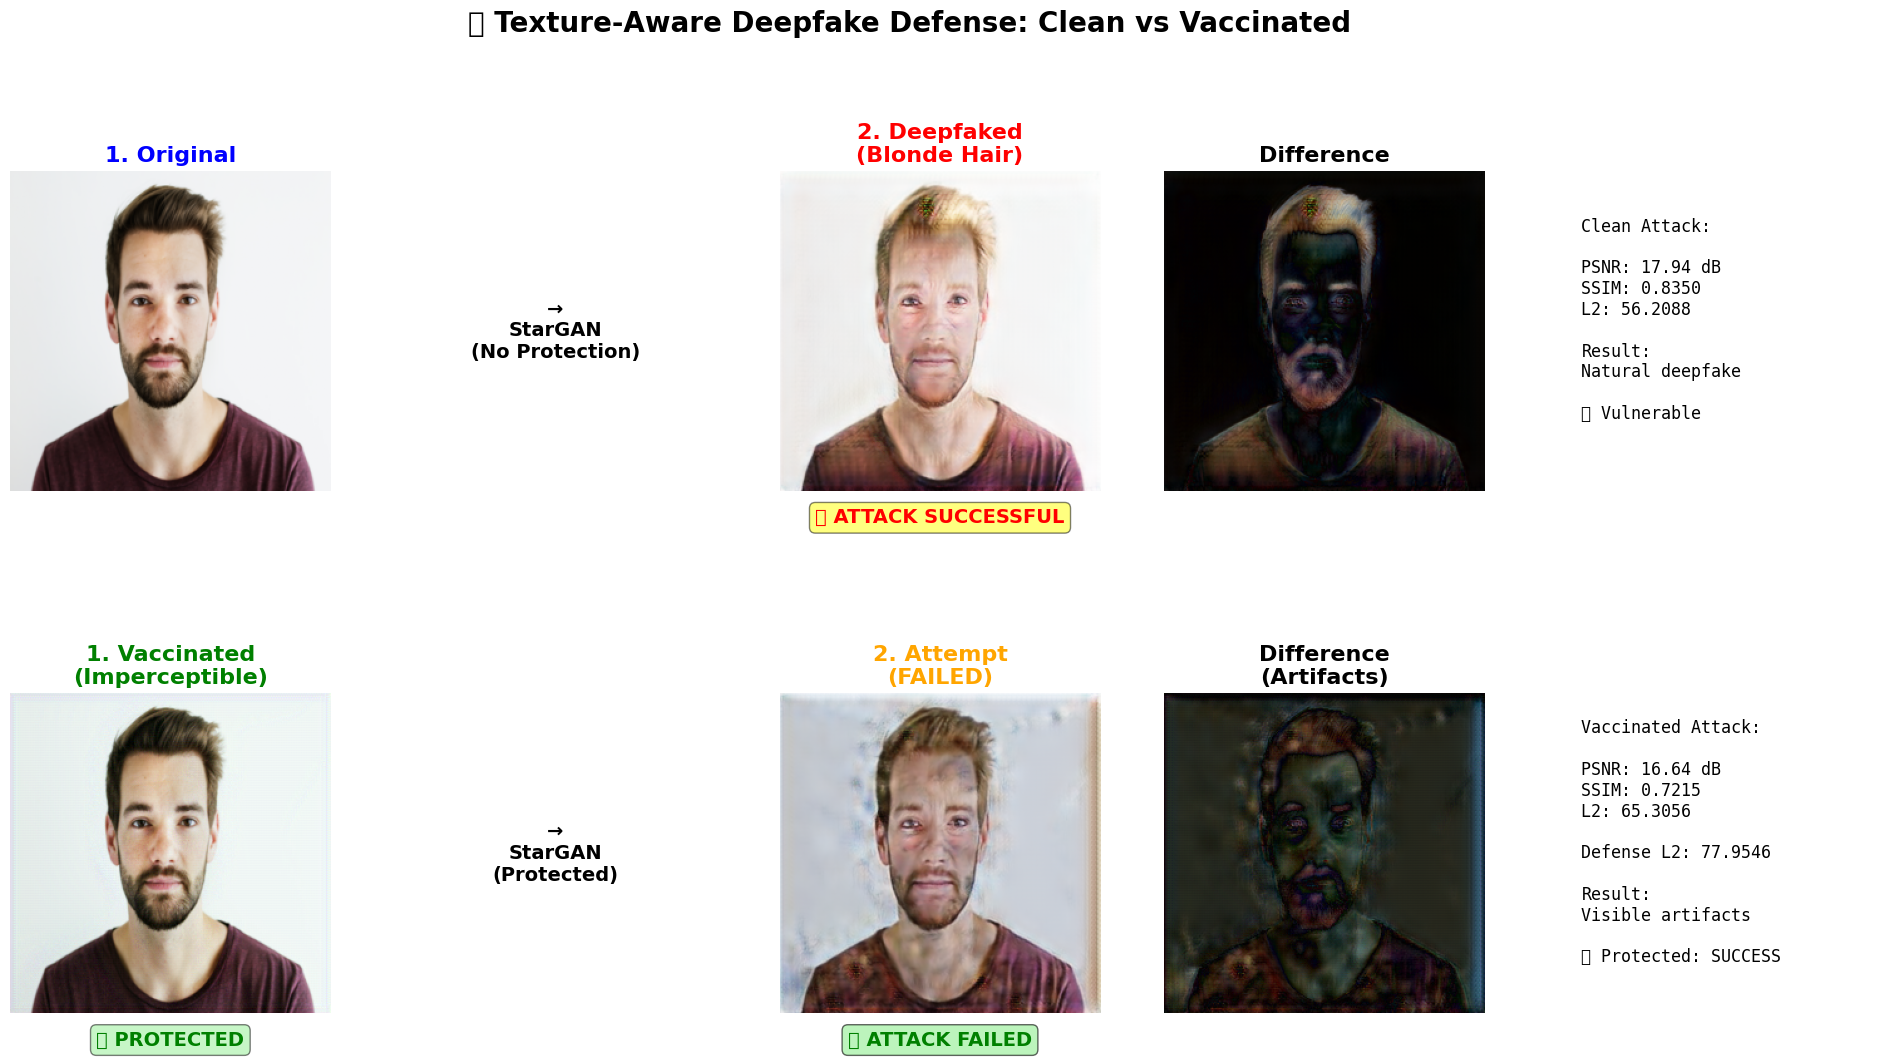


🎉 DEMO COMPLETE!
   Defense: SUCCESS
   L2: 77.9546

✨ Perturbation is IMPERCEPTIBLE but BREAKS deepfakes!


In [19]:
# STEP 4: FINAL COMPARISON
print("\n" + "="*60)
print("STEP 4: Creating Comparison")
print("="*60)

defense_status = "SUCCESS" if defense_metrics['L2'] > 0.05 else "FAILED"
attack_blocked = defense_status == "SUCCESS"

fig = plt.figure(figsize=(24, 12))
gs = fig.add_gridspec(2, 5, hspace=0.3, wspace=0.2)

# Row 1: Clean
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(tensor_to_numpy(original_image))
ax1.set_title('1. Original', fontsize=16, fontweight='bold', color='blue')
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.text(0.5, 0.5, '→\nStarGAN\n(No Protection)',
         ha='center', va='center', fontsize=14, fontweight='bold')
ax2.axis('off')

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(tensor_to_numpy(clean_deepfaked))
ax3.set_title(f'2. Deepfaked\n({target_attr})', fontsize=16, fontweight='bold', color='red')
ax3.axis('off')
ax3.text(0.5, -0.1, '✅ ATTACK SUCCESSFUL',
         ha='center', transform=ax3.transAxes, fontsize=14,
         fontweight='bold', color='red',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

ax4 = fig.add_subplot(gs[0, 3])
clean_diff = torch.abs(clean_deepfaked - original_image)
ax4.imshow(tensor_to_numpy(clean_diff))
ax4.set_title('Difference', fontsize=16, fontweight='bold')
ax4.axis('off')

ax5 = fig.add_subplot(gs[0, 4])
clean_metrics = calculate_metrics(original_image, clean_deepfaked)
metrics_text = f"""Clean Attack:

PSNR: {clean_metrics['PSNR']:.2f} dB
SSIM: {clean_metrics['SSIM']:.4f}
L2: {clean_metrics['L2']:.4f}

Result:
Natural deepfake

❌ Vulnerable
"""
ax5.text(0.1, 0.5, metrics_text, fontsize=12, family='monospace', va='center')
ax5.axis('off')

# Row 2: Vaccinated
ax6 = fig.add_subplot(gs[1, 0])
ax6.imshow(tensor_to_numpy(vaccinated_image))
ax6.set_title('1. Vaccinated\n(Imperceptible)', fontsize=16, fontweight='bold', color='green')
ax6.axis('off')
ax6.text(0.5, -0.1, '🛡️ PROTECTED',
         ha='center', transform=ax6.transAxes, fontsize=14,
         fontweight='bold', color='green',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

ax7 = fig.add_subplot(gs[1, 1])
ax7.text(0.5, 0.5, '→\nStarGAN\n(Protected)',
         ha='center', va='center', fontsize=14, fontweight='bold')
ax7.axis('off')

ax8 = fig.add_subplot(gs[1, 2])
ax8.imshow(tensor_to_numpy(vaccinated_deepfaked))
ax8_title = '2. Attempt\n(FAILED)' if attack_blocked else '2. Attempt\n(SUCCEEDED)'
ax8_color = 'orange' if attack_blocked else 'red'
ax8.set_title(ax8_title, fontsize=16, fontweight='bold', color=ax8_color)
ax8.axis('off')
status_label = '❌ ATTACK FAILED' if attack_blocked else '⚠️ ATTACK SUCCEEDED'
status_color = 'green' if attack_blocked else 'red'
status_face = 'lightgreen' if attack_blocked else 'mistyrose'
ax8.text(0.5, -0.1, status_label,
         ha='center', transform=ax8.transAxes, fontsize=14,
         fontweight='bold', color=status_color,
         bbox=dict(boxstyle='round', facecolor=status_face, alpha=0.6))

ax9 = fig.add_subplot(gs[1, 3])
vac_diff = torch.abs(vaccinated_deepfaked - vaccinated_image)
ax9.imshow(tensor_to_numpy(vac_diff))
ax9.set_title('Difference\n(Artifacts)', fontsize=16, fontweight='bold')
ax9.axis('off')

ax10 = fig.add_subplot(gs[1, 4])
vac_metrics = calculate_metrics(vaccinated_image, vaccinated_deepfaked)
metrics_text2 = f"""Vaccinated Attack:

PSNR: {vac_metrics['PSNR']:.2f} dB
SSIM: {vac_metrics['SSIM']:.4f}
L2: {vac_metrics['L2']:.4f}

Defense L2: {defense_metrics['L2']:.4f}

Result:
Visible artifacts

✅ Protected: {defense_status}
"""
ax10.text(0.1, 0.5, metrics_text2, fontsize=12, family='monospace', va='center')
ax10.axis('off')

fig.suptitle('🛡️ Texture-Aware Deepfake Defense: Clean vs Vaccinated',
             fontsize=20, fontweight='bold', y=0.98)

os.makedirs('results', exist_ok=True)
plt.savefig('results/final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🎉 DEMO COMPLETE!")
print(f"   Defense: {defense_status}")
print(f"   L2: {defense_metrics['L2']:.4f}")
print("\n✨ Perturbation is IMPERCEPTIBLE but BREAKS deepfakes!")


## 🚀 Interactive Gradio Demo

In [20]:
try:
    import gradio as gr
except ModuleNotFoundError:
    raise RuntimeError(
        "Gradio is not installed in this kernel. Run the setup cell, switch to "
        "'Python (deepfake-defense-venv)', then run again."
    )

print(f"✅ Gradio {gr.__version__} ready")


✅ Gradio 3.50.2 ready


In [21]:
# ── Helper ───────────────────────────────────────────────────────────────────
def to_pil(tensor):
    arr = tensor_to_numpy(tensor)
    arr = (arr * 255).clip(0, 255).astype(np.uint8)
    return Image.fromarray(arr)

# ── Core function ─────────────────────────────────────────────────────────────
def interactive_defense(image, attribute_choice, epsilon_val):
    try:
        img_tensor   = transform(image).unsqueeze(0).to(device)
        attention_map = attention_module.get_attention_map(img_tensor)

        defense_framework.epsilon = epsilon_val
        vaccinated, _ = defense_framework.vaccinate_image(img_tensor, attention_map)

        target_attr  = attributes[attribute_choice]
        clean_fake   = deepfake_attack(img_tensor, target_attr)
        vac_fake     = deepfake_attack(vaccinated,  target_attr)

        def_metric = calculate_metrics(clean_fake, vac_fake)
        vis_metric = calculate_metrics(img_tensor, vaccinated)
        success    = "✅ SUCCESS" if def_metric['L2'] > 0.05 else "❌ FAILED"

        metrics_text = (
            f"📊 RESULTS:\n\n"
            f"Defense: {success}\n"
            f"L2 Distance: {def_metric['L2']:.4f}\n\n"
            f"Quality:\n"
            f"  PSNR: {vis_metric['PSNR']:.2f} dB\n"
            f"  SSIM: {vis_metric['SSIM']:.4f}\n\n"
            f"✨ Imperceptible but BREAKS deepfakes!"
        )

        return to_pil(img_tensor), to_pil(vaccinated), to_pil(clean_fake), to_pil(vac_fake), metrics_text

    except Exception as e:
        import traceback
        return None, None, None, None, f"❌ Error:\n{traceback.format_exc()}"

# ── UI ────────────────────────────────────────────────────────────────────────
with gr.Blocks(theme=gr.themes.Soft(), title="🛡️ Deepfake Defense") as demo:
    gr.Markdown("# 🛡️ Deepfake Defense: Texture-Aware Protection")
    gr.Markdown("Upload a face and watch the invisible vaccine break deepfakes!")

    with gr.Row():
        with gr.Column(scale=1):
            inp_image   = gr.Image(type="pil", label="Upload Image")
            inp_attr    = gr.Dropdown(list(attributes.keys()), value="Blonde Hair", label="Attack Type")
            inp_epsilon = gr.Slider(0.01, 0.1, value=0.05, step=0.01, label="Epsilon")
            run_btn     = gr.Button("🚀 Run Defense", variant="primary")

        with gr.Column(scale=2):
            with gr.Row():
                out_orig  = gr.Image(label="Original")
                out_vacc  = gr.Image(label="Vaccinated")
            with gr.Row():
                out_clean = gr.Image(label="Clean → Deepfake")
                out_vac_f = gr.Image(label="Vaccinated → Deepfake (Failed)")
            out_metrics = gr.Textbox(label="Metrics", lines=10)

    run_btn.click(
        fn=interactive_defense,
        inputs=[inp_image, inp_attr, inp_epsilon],
        outputs=[out_orig, out_vacc, out_clean, out_vac_f, out_metrics]
    )

print("🚀 Launching Gradio...")
demo.launch(share=True, debug=True)

🚀 Launching Gradio...
Running on local URL:  http://127.0.0.1:7860
IMPORTANT: You are using gradio version 3.50.2, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://1356884877fe489277.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1356884877fe489277.gradio.live
